We have a web-scraped dataset from the NIST website for spectral lines
https://physics.nist.gov/PhysRefData/ASD/lines_form.html

This was compiled into a set of .npy files (numpy archive) under the slim_db directory
This code further processes that data into a single python pickle file containing the following:


In [5]:
#Imports and env
import numpy as np
#import glob
import re
import pickle
from pathlib import Path
from matplotlib import pyplot as plt
top_dir = Path.cwd().parent #working directory for notebook should be location of notebook
rel_path = 'data' 
datapath = top_dir / rel_path

In [ ]:
#Pre-process database to dict. element key with array of [wavelength,relative intensity]
files = (datapath / 'slim_db').glob('*')
atom_dict = {}  #of form {element:ndarray[[wavelength, rel_intensity]]}


#database missing data for these elements, need to check source?
#no_lines = ['Se', 'Zr', 'Nb', 'Pr', 'Pm', 'Tb', 'Lu', 'Hf', 'Re', 'Os', 'Hg', 
#            'Tl', 'Bi', 'Po', 'At', 'Rn', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu',
#            'Am', 'Cm', 'Bk', 'Cf', 'Es', "Rn", "Pu"] 

#check basic setup for inclusion of unavailable elements
#for el in no_lines:
#    if el in el_include:
#        raise ValueError("Trying to include an element with no spectral data")

for file in files:
    #get element from filename
    m = re.search('([A-Za-z]+).npy$', file.name)
    element = m[1]
    
 #   if element in no_lines or element not in el_include:
 #       #print('Skipping: ', element)
 #       continue
    #print('Processing: ', element)
    
    #load file data into ndarray
    #'element', 'sp_num', 'obs_wl_vac(nm)', 'ritz_wl_vac(nm)', 'intens', 'gA(s^-1)', 'Acc', 'Ei(eV)', 'Ek(eV)', 'conf_i',
    #'term_i', 'J_i', 'conf_k', 'term_k', 'J_k', 'g_i', 'g_k', 'Type', 'tp_ref', 'line_ref'
    try:
        filedata = np.load(file)
        #drop headers, keep only wavelength(3), g_a(5) and g_k(16)
        filedata = filedata[1:,[3,5,16]]
        #note this is string data at this point, which may be helpful through the grouping stage!
        #type(filedata[0,0]) #numpy.str_
        #convert the g_A data to A_ki data which is ~ to intensity
        #However, some wavelengths have '+' so clean that up now. Using loop, look for native array op
        for i in range(filedata.shape[0]):
            filedata[i,0] = re.search('[0-9]+.[0-9]+',filedata[i,0])[0]

        wvlengths = filedata[:,0] #array of strings in numeric format
        filedata[:,1] = (filedata[:,1].astype(float) / filedata[:,2].astype(float))
        #drop the g_k col
        filedata = filedata[:,0:2]
        #note everything is still string data because that's the datatype of the array! will change later
        #next we aggregate by unique wavelength (e.g Li has multiple rows/probs at same wl)
        #clever example here of using np.split to group
        #https://stackoverflow.com/questions/38013778/is-there-any-numpy-group-by-function
        #sort by wavelength
        filedata = filedata[filedata[:,0].astype(float).argsort()]
        #find the breakpoint indices which define each group/wavelength, skip first value
        unique_ind = np.unique(filedata[:, 0], return_index=True)[1][1:]
        wavegroups = np.split(filedata[:,1], unique_ind)#list of arrays. Array contains intensity values to sum for wl
        #sum the intensities at each distinct wl
        wavesums = np.array([np.sum(intens_arr.astype(float)) for intens_arr in wavegroups])
        #add the first wavelength index back to array of unique value indices
        unique_ind = np.append(0, unique_ind)
        if len(unique_ind) == len(wavesums):
            atom_dict[element] = np.column_stack((filedata[:,0][unique_ind].astype(float),
                                                wavesums.astype(float)/np.sum(wavesums.astype(float))))
    except: 
        print(f"could not process {file.name}")


atom keys: 72


<function matplotlib.pyplot.show(close=None, block=None)>

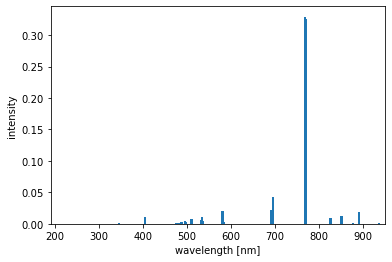

In [7]:
#check number of elements processed
print(f"atom keys: {len(atom_dict.keys())}")
#update element to see atomic spectra
elem = "K"
x_spec=atom_dict[elem][:,0]
y_spec=atom_dict[elem][:,1]
plt.bar(x=x_spec, height = y_spec, width=5) #note width impacts line vis
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
plt.xlim([190, 950]) #note data may go beyond this range
plt.show

In [ ]:
#check against mike's 77 elements for difference
with open(datapath / 'rel_int/valid77_spec.pickle', 'rb') as f:
    mike_atom_dict = pickle.load(f)

for k,v in mike_atom_dict.items():
    matt_key=None
    for k2,v2 in atom_dict.items():
        if k2==k:
            matt_key=k2
    print(f"{k} finds atom dict {matt_key}")

#Missing in matt's ['Hg', 'Hf', 'Tl', 'Bi', 'Lu', 'Ac']


In [28]:
#Troubleshoot differences
file = datapath / 'slim_db' / 'Hg.npy'
filedata = np.load(file)
#drop headers, keep only wavelength(3), g_a(5) and g_k(16)
filedata = filedata[1:,[3,5,16]]
        #note this is string data at this point, which may be helpful through the grouping stage!
        #type(filedata[0,0]) #numpy.str_
        #convert the g_A data to A_ki data which is ~ to intensity
        #However, some wavelengths have '+' so clean that up now. Using loop, look for native array op
#for i in range(filedata.shape[0]):
    #filedata[i,0] = re.search('[0-9]+.[0-9]+',filedata[i,0])[0]

#wvlengths = filedata[:,0] #array of strings in numeric format
#filedata[:,1] = (filedata[:,1].astype(float) / filedata[:,2].astype(float))
        #drop the g_k col
#filedata = filedata[:,0:2]
        #note everything is still string data because that's the datatype of the array! will change later
        #next we aggregate by unique wavelength (e.g Li has multiple rows/probs at same wl)
        #clever example here of using np.split to group
        #https://stackoverflow.com/questions/38013778/is-there-any-numpy-group-by-function
        #sort by wavelength
#filedata = filedata[filedata[:,0].astype(float).argsort()]
        #find the breakpoint indices which define each group/wavelength, skip first value
#unique_ind = np.unique(filedata[:, 0], return_index=True)[1][1:]
#wavegroups = np.split(filedata[:,1], unique_ind)#list of arrays. Array contains intensity values to sum for wl
        #sum the intensities at each distinct wl
#wavesums = np.array([np.sum(intens_arr.astype(float)) for intens_arr in wavegroups])
        #add the first wavelength index back to array of unique value indices
#unique_ind = np.append(0, unique_ind)
#if len(unique_ind) == len(wavesums):
    #atom_dict[element] = np.column_stack((filedata[:,0][unique_ind].astype(float),
                            #wavesums.astype(float)/np.sum(wavesums.astype(float))))

In [29]:
filedata

array([['', 'L3456', '(2D<5/2>,3P<2>)*'],
       ['3D', '3', ''],
       ['302.23841', '3.6e+08', '7'],
       ['407.89883', '4.0e+06', '1'],
       ['1D', '3', ''],
       ['', 'L15167c86', '3D']], dtype='<U22')

In [4]:
#persist the data for ongoing usage
#with open(datapath / 'rel_int/valid72_spec.pickle', 'wb') as f:
# Pickle the relative intensity spectra with default protocol (4 as of py3.8)
 #   pickle.dump(atom_dict, f)

#To load in other modules at top level of repo
#import pickle
#with open(datapath / 'rel_int/top30_spec.pickle', 'rb') as f:
#    atom_dict = pickle.load(f)

In [18]:
#confirm
print(type(atom_dict["Li"])) #numpy.ndarray
print(atom_dict["Li"].shape) #(53, 2)
print(type(atom_dict["Li"][0])) #numpy.ndarray
print(type(atom_dict["Li"][0][0])) #numpy.float64
print(type(atom_dict["Li"][0][1])) #numpy.float64
atom_dict["Li"][0] #array([2.33465300e+02, 5.79060572e-04])

<class 'numpy.ndarray'>
(53, 2)
<class 'numpy.ndarray'>
<class 'numpy.float64'>
<class 'numpy.float64'>


array([2.33465300e+02, 5.79060572e-04])